In [56]:
import pandas as pd
import numpy as np
import os
import requests
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import squarify 
from wordcloud import WordCloud 

% matplotlib inline
sns.set(style = 'white')
pd.options.display.float_format = '{0:,.2f}'.format

## Data Gathering

### CSV Data

In [14]:
twitter_df = pd.read_csv('twitter-archive-enhanced-2.csv')
twitter_df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


### Internet Data

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [4]:
response = requests.get(url)

In [3]:
with open('image_predictions.tsv','wb') as predictions_file:
    predictions_file.write(response.content)

NameError: name 'response' is not defined

In [15]:
predict_df = pd.read_csv('image_predictions.tsv', sep = '\t')

In [16]:
predict_df.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


### Twitter Data

In [28]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

ModuleNotFoundError: No module named 'tweepy'

In [17]:
import json

In [ ]:
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

In [ ]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
count = 0
fails_dict = {}
start = timer()

In [ ]:
with open('tweet_json.txt', 'w') as outfile:
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [18]:
dfcolumns = ['tweet_id','retweet_count','favorite_count']
df_list = []
with open('tweet_json.txt','r',encoding='utf-8') as file: 
    for line in file:
        line_data = json.loads(line)
        df_list.append({'tweet_id':line_data.get('id'),
                       'retweet_count':line_data.get('retweet_count'),
                       'favorite_count':line_data.get('favorite_count')})
tweet_df = pd.DataFrame(df_list,columns=dfcolumns)
tweet_df.head(3)
            

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461


## Twitter Archive Cleanup

### Backup Data

In [19]:
df = twitter_df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

### Remove Unneeded Columns

In [20]:
drop_columns = ['timestamp','source','retweeted_status_timestamp','expanded_urls']
df.drop(columns = drop_columns,inplace=True)
df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,This is Tilly. She's just checking pup on you....,NaN,NaN,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,12,10,Archie,None,None,None,None


### Refactor Dog Stage Data

In [21]:
#create the new column by merging the values
df['dog_stage'] = df.doggo+df.floofer+df.pupper+df.puppo

In [22]:
#replace the None sequence so as to leave only the real type
df.dog_stage = df.dog_stage.str.replace('None','')

In [23]:
#replace blank with nan so as to identify missing values easier
df.dog_stage.replace('',np.nan,inplace=True)

In [24]:
#drop the old columns
df.drop(columns=['doggo','floofer','pupper','puppo'],inplace=True)

In [25]:
df.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,NaN,NaN,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,This is Tilly. She's just checking pup on you....,NaN,NaN,13,10,Tilly,NaN
2,891815181378084864,NaN,NaN,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,12,10,Archie,NaN
3,891689557279858688,NaN,NaN,This is Darla. She commenced a snooze mid meal...,NaN,NaN,13,10,Darla,NaN
4,891327558926688256,NaN,NaN,This is Franklin. He would like you to stop ca...,NaN,NaN,12,10,Franklin,NaN


### Cleanup Denominator Data

In [26]:
df[df.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,name,dog_stage
313,835246439529840640,8.352460e+17,2.625958e+07,@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,960,0,None,NaN
342,832088576586297345,8.320875e+17,3.058208e+07,@docmisterio account started on 11/15/15,NaN,NaN,11,15,None,NaN
433,820690176645140481,NaN,NaN,The floofs have been released I repeat the flo...,NaN,NaN,84,70,None,NaN
516,810984652412424192,NaN,NaN,Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,24,7,Sam,NaN
784,775096608509886464,NaN,NaN,"RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,9,11,None,NaN
902,758467244762497024,NaN,NaN,Why does this never happen at my front door......,NaN,NaN,165,150,None,NaN
1068,740373189193256964,NaN,NaN,"After so many requests, this is Bretagne. She ...",NaN,NaN,9,11,None,NaN
1120,731156023742988288,NaN,NaN,Say hello to this unbelievably well behaved sq...,NaN,NaN,204,170,this,NaN
1165,722974582966214656,NaN,NaN,Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,4,20,None,NaN
1202,716439118184652801,NaN,NaN,This is Bluebert. He just saw that both #Final...,NaN,NaN,50,50,Bluebert,NaN


Most cases the problem is that the tweet is about a whole group of dogs. 
We are going to remove all rows where the denominator is not 10 and the name of the dog is missing. 

In [27]:
df.drop(df[(df.rating_denominator != 10) & (df.name == 'None')].index, inplace=True)

In [28]:
#Test the rows are not there
df[(df.rating_denominator != 10) & (df.name == 'None')].index

Int64Index([], dtype='int64')

In [29]:
#checking the remaining cases
df[df.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,name,dog_stage
516,810984652412424192,NaN,NaN,Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,24,7,Sam,NaN
1120,731156023742988288,NaN,NaN,Say hello to this unbelievably well behaved sq...,NaN,NaN,204,170,this,NaN
1202,716439118184652801,NaN,NaN,This is Bluebert. He just saw that both #Final...,NaN,NaN,50,50,Bluebert,NaN
1351,704054845121142784,NaN,NaN,Here is a whole flock of puppers. 60/50 I'll ...,NaN,NaN,60,50,a,NaN
1662,682962037429899265,NaN,NaN,This is Darrel. He just robbed a 7/11 and is i...,NaN,NaN,7,11,Darrel,NaN
2335,666287406224695296,NaN,NaN,This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,1,2,an,NaN


In [30]:
#By looking at the text we can manually discard the following rows 
#as they are either belonging to group of dogs or to dogs with missing name or rating: 
drop_rows = [516,1120,1351,2335]
df.drop(drop_rows,inplace=True)

In [31]:
#checking the remaining cases
df[df.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,name,dog_stage
1202,716439118184652801,NaN,NaN,This is Bluebert. He just saw that both #Final...,NaN,NaN,50,50,Bluebert,NaN
1662,682962037429899265,NaN,NaN,This is Darrel. He just robbed a 7/11 and is i...,NaN,NaN,7,11,Darrel,NaN


In [32]:
#For the remaining two cases we need to fix the rating as it's incorrect:
#Bluebert is a 11/10
# Darrel is a 10/10
df.rating_denominator = 10
df.at[1202,'rating_numerator'] = 11
df.at[1662,'rating_numerator'] = 10

In [33]:
#Final test should return 0
df[df.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,name,dog_stage


In [34]:
#Now that all the denominators are 10 there is no reason to have two columns for the rating so we will merge
df['rating'] = df.rating_numerator / df.rating_denominator

In [35]:
df['rating'].head(3)

0    1.3
1    1.3
2    1.2
Name: rating, dtype: float64

In [36]:
#And drop the former columns
df.drop(columns=['rating_denominator','rating_numerator'],inplace=True)
df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,name,dog_stage,rating
0,892420643555336193,NaN,NaN,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,Phineas,NaN,1.3
1,892177421306343426,NaN,NaN,This is Tilly. She's just checking pup on you....,NaN,NaN,Tilly,NaN,1.3
2,891815181378084864,NaN,NaN,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,Archie,NaN,1.2


### Restore to Original Dataframe

In [37]:
twitter_df = df.copy()

## Predictions Data

### Backup data

In [38]:
df = predict_df.copy()
df.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Drop Unused Data

In [39]:
df.drop(columns=['jpg_url','img_num'], inplace=True)

In [40]:
df.head(3)

,tweet_id,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


### Data Summary

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 10 columns):
tweet_id    2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(3)
memory usage: 119.6+ KB


### Remove Non Dog Predictions

In [42]:
#drop all rows which do not predict a dog
df.drop(df[(df.p1_dog == False) & (df.p2_dog == False) & (df.p3_dog == False)].index,inplace=True)

In [43]:
df[(df.p1_dog == False) & (df.p2_dog == False) & (df.p3_dog == False)].index

Int64Index([], dtype='int64')

Since the there are cases in which the second or third options are dogs we need a different approach for this

In [44]:
new_columns = ['tweet_id','breed','prob','is_dog']

In [45]:
df_1a = df[df.p1_dog == True][['tweet_id','p1','p1_conf','p1_dog']]
df_1a.columns = new_columns
df_1a.head(3)

,tweet_id,breed,prob,is_dog
0,666020888022790149,Welsh_springer_spaniel,0.465074,True
1,666029285002620928,redbone,0.506826,True
2,666033412701032449,German_shepherd,0.596461,True


In [46]:
df_2a = df[df.p2_dog == True][['tweet_id','p2','p2_conf','p2_dog']]
df_2a.columns = new_columns
df_2a.head(3)

,tweet_id,breed,prob,is_dog
0,666020888022790149,collie,0.156665,True
1,666029285002620928,miniature_pinscher,0.074192,True
2,666033412701032449,malinois,0.138584,True


In [47]:
df_3a = df[df.p3_dog == True][['tweet_id','p3','p3_conf','p3_dog']]
df_3a.columns = new_columns
df_3a.head(3)

,tweet_id,breed,prob,is_dog
0,666020888022790149,Shetland_sheepdog,0.061428,True
1,666029285002620928,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,bloodhound,0.116197,True


In [48]:
#bring together all the dataframes and drop the is dog columns since it's true for all
df = pd.concat([df_1a,df_2a,df_3a])
df.drop(columns=['is_dog'],inplace=True)
#sort the rows by probability
df.sort_values(by=['prob'],ascending=False,inplace=True)
#remove the duplicates based on tweet ids
#thus we ensure we have only one prediction per tweet, the one with the highest probability for a dog
df.drop_duplicates(subset=['tweet_id'],inplace=True)
df.reset_index(drop=True,inplace=True)
df.head(3)

,tweet_id,breed,prob
0,668636665813057536,komondor,0.999956
1,762464539388485633,chow,0.999953
2,697463031882764288,Labrador_retriever,0.999885


### Remove low probability data

In [49]:
#let's look at the values distribution for the probability 
df.prob.describe()

count    1751.000000
mean        0.548992
std         0.298804
min         0.000010
25%         0.303098
50%         0.548907
75%         0.820481
max         0.999956
Name: prob, dtype: float64

In [50]:
#remove the data with a probability of less than 10% of being that specific breed
df.drop(df[df.prob < 0.1].index,inplace=True)
df.prob.describe()

count    1604.000000
mean        0.594937
std         0.268726
min         0.100418
25%         0.367736
50%         0.596458
75%         0.839105
max         0.999956
Name: prob, dtype: float64

### Restore to Original Dataframe

In [51]:
predict_df = df.copy()

## Merging it together

In [52]:
twitter_df = twitter_df.join(predict_df.set_index('tweet_id'), on='tweet_id', how='left')
twitter_df = twitter_df.join(tweet_df.set_index('tweet_id'),on='tweet_id',how='left')
twitter_df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,name,dog_stage,rating,breed,prob,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,Phineas,NaN,1.3,NaN,NaN,8853.0,39467.0
1,892177421306343426,NaN,NaN,This is Tilly. She's just checking pup on you....,NaN,NaN,Tilly,NaN,1.3,Chihuahua,0.323581,6514.0,33819.0
2,891815181378084864,NaN,NaN,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,Archie,NaN,1.2,Chihuahua,0.716012,4328.0,25461.0


In [53]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2335 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id                    2335 non-null int64
in_reply_to_status_id       73 non-null float64
in_reply_to_user_id         73 non-null float64
text                        2335 non-null object
retweeted_status_id         180 non-null float64
retweeted_status_user_id    180 non-null float64
name                        2335 non-null object
dog_stage                   380 non-null object
rating                      2335 non-null float64
breed                       1590 non-null object
prob                        1590 non-null float64
retweet_count               2333 non-null float64
favorite_count              2333 non-null float64
dtypes: float64(8), int64(1), object(4)
memory usage: 255.4+ KB


In [54]:
df = twitter_df.copy()

### Changing Data Types

In [55]:
df.retweet_count = df.retweet_count.fillna(0)
df.favorite_count = df.favorite_count.fillna(0)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2335 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id                    2335 non-null int64
in_reply_to_status_id       73 non-null float64
in_reply_to_user_id         73 non-null float64
text                        2335 non-null object
retweeted_status_id         180 non-null float64
retweeted_status_user_id    180 non-null float64
name                        2335 non-null object
dog_stage                   380 non-null object
rating                      2335 non-null float64
breed                       1590 non-null object
prob                        1590 non-null float64
retweet_count               2335 non-null float64
favorite_count              2335 non-null float64
dtypes: float64(8), int64(1), object(4)
memory usage: 255.4+ KB


In [57]:
df.retweet_count = df.retweet_count.astype(int)
df.favorite_count = df.favorite_count.astype(int)

In [58]:
df.drop(columns=['prob'],inplace=True)

In [59]:
df.dog_stage = df.dog_stage.astype('category')

### Rating Corrections

In [60]:
df.rating.describe()

count    2335.000000
mean        1.223597
std         4.100493
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: rating, dtype: float64

In [61]:
df[df.rating > 2]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,name,dog_stage,rating,breed,retweet_count,favorite_count
188,855862651834028034,8.558616e+17,194351775.0,@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,None,NaN,42.0,NaN,27,320
189,855860136149123072,8.558585e+17,13615722.0,@s8n You tried very hard to portray this good ...,NaN,NaN,None,NaN,66.6,NaN,1058,4407
290,838150277551247360,8.381455e+17,21955058.0,@markhoppus 182/10,NaN,NaN,None,NaN,18.2,NaN,370,1824
340,832215909146226688,NaN,NaN,"RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,Logan,NaN,7.5,NaN,7069,0
695,786709082849828864,NaN,NaN,"This is Logan, the Chow who lived. He solemnly...",NaN,NaN,Logan,NaN,7.5,Pomeranian,7069,20296
763,778027034220126208,NaN,NaN,This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,Sophie,pupper,2.7,clumber,1885,7320
979,749981277374128128,NaN,NaN,This is Atticus. He's quite simply America af....,NaN,NaN,Atticus,NaN,177.6,NaN,2772,5569
1712,680494726643068929,NaN,NaN,Here we have uncovered an entire battalion of ...,NaN,NaN,None,NaN,2.6,kuvasz,542,1879
2074,670842764863651840,NaN,NaN,After so many requests... here you go.\n\nGood...,NaN,NaN,None,NaN,42.0,NaN,4324,7989


In [62]:
#First and last entries above are duplicates about snoop dog. Will remove one and update the name 
df.drop(188,inplace=True)

In [63]:
df.at[2074,'name'] = 'SnoopDogg'

In [64]:
# The 1776 one is legit. Was manually checked

In [65]:
#Logan is actually 9.75 / 10 (and also a retweet)
df.drop(340,inplace=True)
df.at[695,'rating'] = 0.975

In [ ]:
#666 rating is legit. checked manually and it appears it's Satan's dog

In [66]:
# the 182 rating we don't have any breed, name or context to the rating so it will be removed 
df.drop(290,inplace=True)

In [67]:
# for the 26 and 27 ratings it's actually a mistake as the rating is in fractions 11.27 and 11.26
df.at[763,'rating'] = 1.127
df.at[1712,'rating'] = 1.126

### Duplicates

In [95]:
sum(df.text.duplicated())

0

In [96]:
sum(df.tweet_id.duplicated())

0

In [68]:
df[(df.name.duplicated()) & (df.name != 'None')]['name'].value_counts()

a           53
Charlie     11
Cooper      10
Oliver      10
Lucy        10
Tucker       9
Penny        9
Lola         9
Bo           8
Winston      8
the          7
Sadie        7
Buddy        6
Toby         6
Bailey       6
Daisy        6
Scout        5
Dave         5
Stanley      5
Oscar        5
an           5
Koda         5
Milo         5
Rusty        5
Bella        5
Leo          5
Jax          5
Jack         5
very         4
Sammy        4
            ..
Sarge        1
Frank        1
Fizz         1
Trooper      1
Ash          1
Elliot       1
Flávio       1
Watson       1
Raymond      1
Hercules     1
Atlas        1
Panda        1
CeCe         1
Dawn         1
Pickles      1
Luca         1
Stubert      1
Benedict     1
Coops        1
Jackson      1
Wally        1
Layla        1
Klein        1
Canela       1
Jiminy       1
Yogi         1
Phineas      1
Sandy        1
Lou          1
Mattie       1
Name: name, Length: 292, dtype: int64

In [69]:
name_remove = (['a','the','an','very'])
for index in df[df.name.isin(name_remove)].index:
    df.at[index,'name'] = 'None'


### Retweets

In [70]:
#get the list of all retweets
retweets = (df[df.retweeted_status_id.isnull() != True].retweeted_status_id)

In [71]:
#check which ones we actually have in the dataset so that we do not remove more than needed
retweets = (df[df.tweet_id.isin(retweets)].tweet_id)

In [72]:
#drop the rows with retweets and keep the original since that is the one containing more data
df.drop(df[df.retweeted_status_id.isin(retweets)].index, inplace=True)

In [73]:
df[df.retweeted_status_id.isnull() != True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,name,dog_stage,rating,breed,retweet_count,favorite_count
19,888202515573088257,NaN,NaN,RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,Canela,NaN,1.3,Pembroke,0,0
32,886054160059072513,NaN,NaN,RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,None,NaN,1.2,NaN,108,0
78,877611172832227328,NaN,NaN,RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,None,pupper,1.4,Irish_setter,83,0
91,874434818259525634,NaN,NaN,RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,Coco,NaN,1.2,NaN,15546,0
95,873697596434513921,NaN,NaN,RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,Walter,NaN,1.4,NaN,12518,0
101,872668790621863937,NaN,NaN,RT @loganamnosis: Penelope here is doing me qu...,8.726576e+17,1.547674e+08,None,NaN,1.4,NaN,31,0
130,867072653475098625,NaN,NaN,RT @rachaeleasler: these @dog_rates hats are 1...,8.650134e+17,7.874618e+17,None,NaN,1.3,Blenheim_spaniel,135,0
132,866816280283807744,NaN,NaN,RT @dog_rates: This is Jamesy. He gives a kiss...,8.664507e+17,4.196984e+09,Jamesy,pupper,1.3,NaN,32883,0
155,861769973181624320,NaN,NaN,"RT @dog_rates: ""Good afternoon class today we'...",8.066291e+17,4.196984e+09,None,NaN,1.3,NaN,37911,0
159,860981674716409858,NaN,NaN,RT @dog_rates: Meet Lorenzo. He's an avid nift...,8.605638e+17,4.196984e+09,Lorenzo,NaN,1.3,NaN,2334,0


### Breeds

In [76]:
df.breed.value_counts()

Golden_retriever                  147
Labrador_retriever                 98
Pembroke                           94
Chihuahua                          87
Pug                                57
Samoyed                            43
Chow                               41
Pomeranian                         41
Toy_poodle                         40
Malamute                           31
French_bulldog                     27
Cocker_spaniel                     27
Chesapeake_bay_retriever           25
Miniature_pinscher                 24
Staffordshire_bullterrier          21
German_shepherd                    21
Shih-tzu                           20
Siberian_husky                     20
Cardigan                           19
Eskimo_dog                         18
Kuvasz                             17
Maltese_dog                        17
Shetland_sheepdog                  17
Beagle                             17
Rottweiler                         17
Italian_greyhound                  17
Lakeland_ter

In [75]:
# the only noticeable issue is the capitalization so we will fix this
df.breed = df.breed.str.capitalize()

In [77]:
columns_drop = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id']
df.drop(columns=columns_drop,inplace=True)
df.head(5)

,tweet_id,text,name,dog_stage,rating,breed,retweet_count,favorite_count
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,Phineas,NaN,1.3,NaN,8853,39467
1,892177421306343426,This is Tilly. She's just checking pup on you....,Tilly,NaN,1.3,Chihuahua,6514,33819
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,Archie,NaN,1.2,Chihuahua,4328,25461
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,Darla,NaN,1.3,Labrador_retriever,8964,42908
4,891327558926688256,This is Franklin. He would like you to stop ca...,Franklin,NaN,1.2,Basset,9774,41048


### Restore to original dataframe and save to file

In [78]:
twitter_df = df.copy()

In [79]:
twitter_df.to_csv('twitter_archive_master.csv')

## Analysis

In [3]:
df = pd.read_csv('twitter_archive_master.csv')

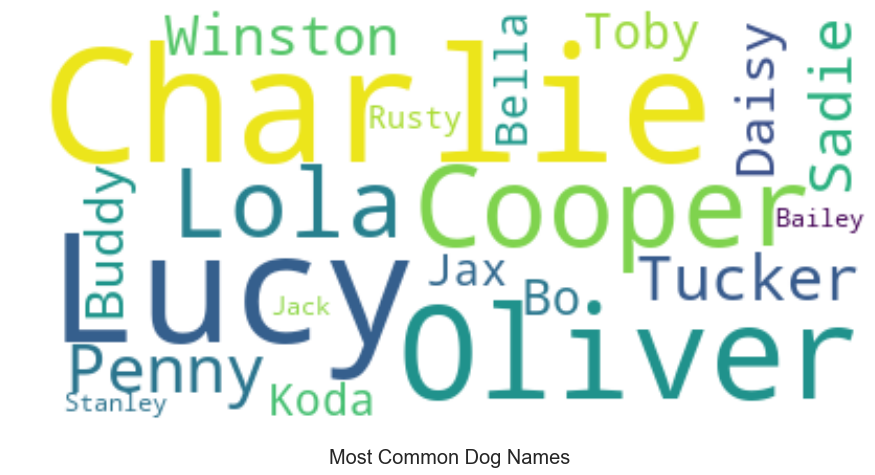

In [26]:
#Wordcloud for dog names

names = list(filter(lambda name: name!='None',df.name))
text = ' '.join(names)
wordcloud = WordCloud(max_words = 20, background_color='white', colormap='viridis').generate(text)

fig = plt.figure(figsize = [15,10])
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.margins(x=0,y=0)
plt.title('Most Common Dog Names',y=-0.1, fontdict={'fontsize':20});

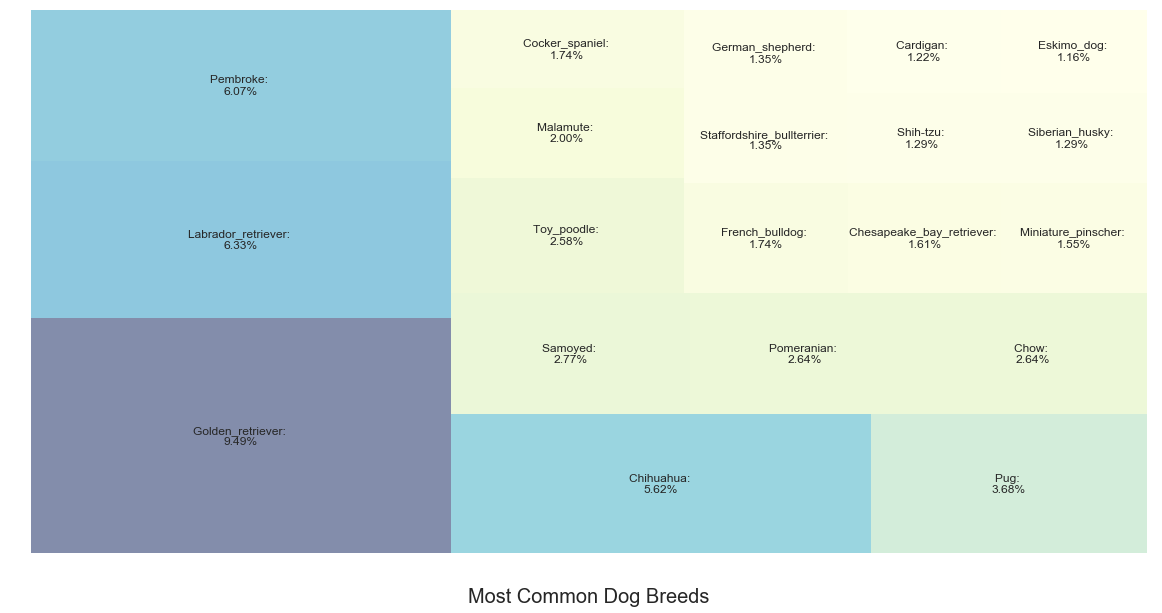

In [71]:
#HeatMap for dog breads
labels = df.breed.value_counts().head(20).keys()
values = df.breed.value_counts().head(20).values

total = df.breed.value_counts().sum()

percentages = []
for value in values:
    percentages.append(value/total)

labels_values = []
for label,percentage in zip(labels,percentages):
    labels_values.append(label + ': \n'+str(percentage*100)[:4]+'%')

fig = plt.figure(figsize = [20,10])
cmap = mpl.cm.YlGnBu
norm = mpl.colors.Normalize(vmin = min(values), vmax = max(values))
colors = [cmap(norm(value)) for value in values]
squarify.plot(sizes=values,label=labels_values, alpha=.5, color=colors);
plt.margins(x=0,y=0)
plt.title('Most Common Dog Breeds',y=-0.1, fontdict={'fontsize':20});
plt.axis('off');

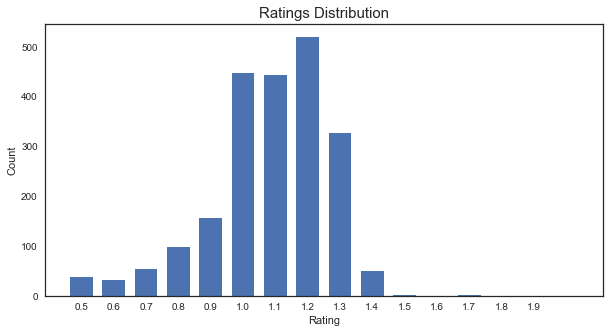

In [97]:
#Rating Distribution
plt.figure(figsize = [10,5])
bins = np.arange(0.45,2.15,0.1)
plt.xticks(np.arange(0.5,2,0.1))
plt.hist(data = df, x='rating',bins=bins,rwidth=0.7)
plt.ylabel('Count')
plt.xlabel('Rating')
plt.title('Ratings Distribution',fontdict={'fontsize':15});

In [105]:
df.drop([124],inplace=True)

In [106]:
#Top retweet
df.sort_values(by='retweet_count',ascending=False).head(10)

,Unnamed: 0,tweet_id,text,name,dog_stage,rating,breed,retweet_count,favorite_count
920,1039,744234799360020481,Here's a doggo realizing you can stand in a po...,None,doggo,1.30,Labrador_retriever,79515,131075
481,534,807106840509214720,This is Stephan. He just wants to help. 13/10 ...,Stephan,NaN,1.30,Chihuahua,56625,107015
958,1079,739238157791694849,Here's a doggo blowing bubbles. It's downright...,None,doggo,1.30,Eskimo_dog,52360,75163
379,413,822872901745569793,Here's a super supportive puppo participating ...,None,puppo,1.30,Lakeland_terrier,48265,132810
65,66,879415818425184262,This is Duddles. He did an attempt. 13/10 some...,Duddles,NaN,1.30,English_springer,45849,107956
407,449,819004803107983360,This is Bo. He was a very good First Doggo. 14...,Bo,doggo,1.40,Standard_poodle,42228,95450
483,537,806629075125202948,"""Good afternoon class today we're going to lea...",None,NaN,1.30,NaN,37911,75639
760,870,761672994376806400,Ohboyohboyohboyohboyohboyohboyohboyohboyohboyo...,None,NaN,1.00,NaN,33421,55016
127,135,866450705531457537,This is Jamesy. He gives a kiss to every other...,Jamesy,pupper,1.30,French_bulldog,32883,106827
1697,1830,676219687039057920,This is Kenneth. He's stuck in a bubble. 10/10...,Kenneth,NaN,1.00,NaN,31989,67100


In [168]:
#Best rated breed 
breeds = df.breed.value_counts().head(20).keys()

ratings = []
retweets = []
favorites = []

for breed in breeds:
    ratings.append(df[df.breed == breed].groupby(['breed'])['rating'].mean()[0])
    retweets.append(df[df.breed == breed].groupby(['breed'])['retweet_count'].mean()[0])
    favorites.append(df[df.breed == breed].groupby(['breed'])['favorite_count'].mean()[0])

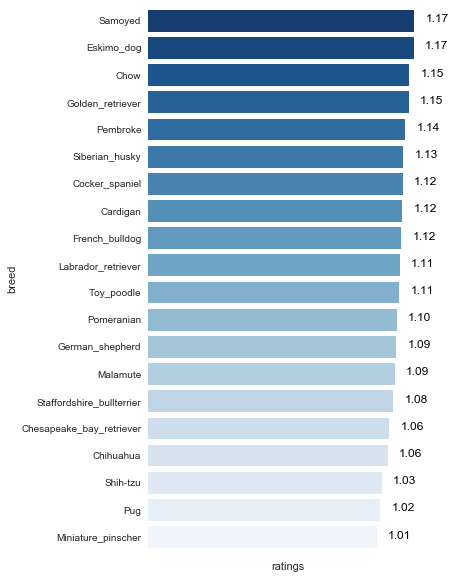

In [169]:
graph_df = pd.DataFrame()
graph_df['breed'] = breeds
graph_df['ratings'] = ratings

graph_df.sort_values(by='ratings',ascending=False,inplace=True)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(5)
for i,v in enumerate(graph_df.ratings):
    ax.text(v+0.05, i+.05, str(v)[:4], color='black')
sns.barplot(x=graph_df.ratings, y=graph_df.breed,ax = ax, palette='Blues_r')
ax.xaxis.set_major_formatter(plt.NullFormatter())
sns.despine(fig,bottom=True,left=True);

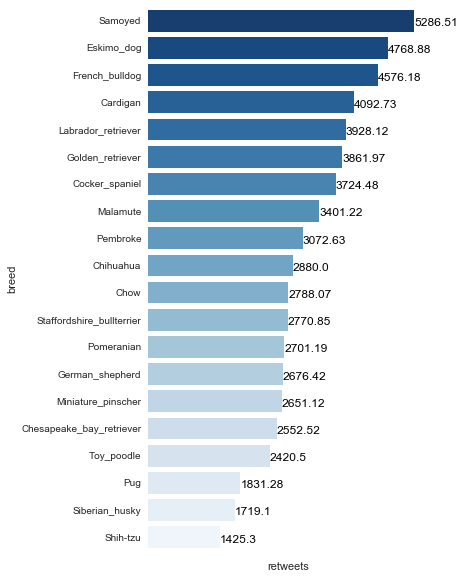

In [171]:
#Most retweeted breed
graph_df = pd.DataFrame()
graph_df['breed'] = breeds
graph_df['retweets'] = retweets

graph_df.sort_values(by='retweets',ascending=False,inplace=True)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(5)
for i,v in enumerate(graph_df.retweets):
    ax.text(v+0.54, i+.2, str(v)[:7], color='black')
sns.barplot(x=graph_df.retweets, y=graph_df.breed,ax = ax, palette='Blues_r')
ax.xaxis.set_major_formatter(plt.NullFormatter())
sns.despine(fig,bottom=True,left=True);

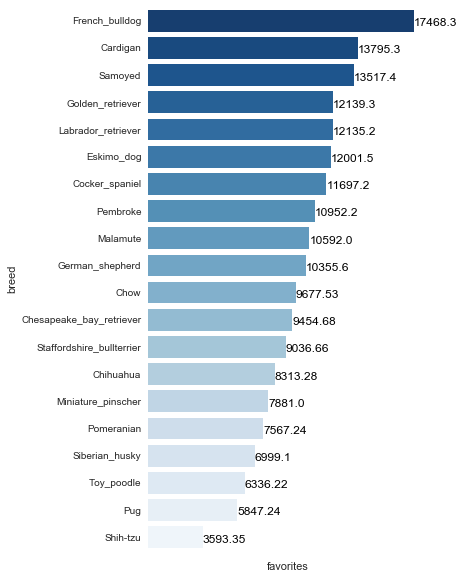

In [172]:
#Most favoured breed
graph_df = pd.DataFrame()
graph_df['breed'] = breeds
graph_df['favorites'] = favorites

graph_df.sort_values(by='favorites',ascending=False,inplace=True)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(5)
for i,v in enumerate(graph_df.favorites):
    ax.text(v+0.54, i+.2, str(v)[:7], color='black')
sns.barplot(x=graph_df.favorites, y=graph_df.breed,ax = ax, palette='Blues_r')
ax.xaxis.set_major_formatter(plt.NullFormatter())
sns.despine(fig,bottom=True,left=True);